# Введение

## Описание задачи
[источник](https://www.kaggle.com/c/ml-posterior-gym-training-prediction)

### EN

A network of sports clubs tracks training sessions conducted by its coaches for clients. If a client wants to sign up for a training session, he/she calls the reception or come in person. The GYM’s staff appoints the appropriate time, the coach and the club. At your disposal, you have a database of several GYMs with this data. The data contains a log of training sessions for 2017 and 2018 in a trainset, and training sessions for 2019 in a testset. There is a boolean target flag for each training session: whether a training session had been.

You face the task of reducing the number of training process skips by identifying factors that affect the skip. For this purpose, you have to build a model that predicts the probability of the client going to the GYM training.

Optional question:

* How could we enrich the data to improve the model quality?

## Описание датасета

### EN

* Id: index of training session
* ClientID: Client who signed up for a training session
* CoachID: Сoach to whom the client signed up
* GymID: GYM center where the training will take place. One client can have trainings in different gyms. Also one coach can have trrainings in different gyms.
* TrainingID: Training type: strength training, cardio, swimming pool, etc
* Time: Scheduled time
* Target: Whether a training session had been: Yes(1) or No(0)

# Подготовка ноутбука

## Первичные константы 

In [216]:
PROJECT_NAME = "Kaggle. ML Posterior. Gym training prediction"
MOUNT_DIR = '/content/drive' # In case Colab Usage
VALIDATE_RATIO = 0.2

## Дополнительные установки

In [217]:
!pip install catboost

## Библиотеки

In [218]:
import os

from datetime import datetime

from collections import Counter

import numpy as np

import pandas as pd

import catboost as ctb
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve


import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size':14})

%matplotlib inline

## Обработка случая работы в Google.Colab

### Подключение библиотек

In [219]:
try:
    from google.colab import files, drive
    
    USE_COLAB = True
except:
    USE_COLAB = False

if USE_COLAB:
    print("Don't forget to avoid disconnections:")
    print("""
function ClickConnect(){
    console.log("Clicking"); 
    document.querySelector("colab-connect-button").click() 
}
setInterval(ClickConnect,60000)
    """)

Don't forget to avoid disconnections:

function ClickConnect(){
    console.log("Clicking"); 
    document.querySelector("colab-connect-button").click() 
}
setInterval(ClickConnect,60000)
    


### Подключение к Google.Drive

In [220]:
if USE_COLAB:
    drive.mount(MOUNT_DIR)
    DRIVE_DIR = os.path.join(MOUNT_DIR, 'My Drive')
    print(f"Drive directory is {DRIVE_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive directory is /content/drive/My Drive


### Установка соединения с Kaggle

In [221]:
if USE_COLAB:
    !pip install -q kaggle
    !mkdir ~/.kaggle
    kaggle_file = os.path.join(DRIVE_DIR, 'kaggle.json')
    !cp "$kaggle_file" ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


## Объявление рабочей директории

Подключение к Google.Drive в случае работы c Google.Colab

In [223]:
PROJECT_DIR = os.path.join(DRIVE_DIR, 'projects', PROJECT_NAME) if USE_COLAB else './'
WORK_DIR = '/content' if USE_COLAB else PROJECT_DIR
print(f"Project directory is {PROJECT_DIR}")
print(f"Working directory is {WORK_DIR}")

Project directory is /content/drive/My Drive/projects/Kaggle. ML Posterior. Gym training prediction
Working directory is /content


# Обработка данных

На выходе должны быть объявлены переменные:

* **X_train**: pd.DataFrame\
Id | ClientID | ClientType | CoachID | GymID | TrainingID | Month | Day
* **y_train**: pd.Series\
Id | Target
* **X_valid**: pd.DataFrame\
Id | ClientID | ClientType | CoachID | GymID | TrainingID | Month | Day
* **y_valid**: pd.Series\
Id | Target
* **X_test**: pd.DataFrame\
Id | ClientID | ClientType | CoachID | GymID | TrainingID | Month | Day

## Загрузка

Загрузка train/test датасета в датафреймы

На выходе должны быть объявлены две переменные:
* train_dataset: pd.Dataframe
* test_dataset: pd.Dataframe

### Скачивание архива


In [224]:
src_data_dir_path = os.path.join(PROJECT_DIR, 'data')
!kaggle competitions download -c ml-posterior-gym-training-prediction  -p "$src_data_dir_path"

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


### Разархивация

In [225]:
src_train_file_path = os.path.join(data_dir_path, 'train.csv.zip')
src_test_file_path = os.path.join(data_dir_path, 'test.csv.zip')
dist_data_dir = os.path.join(WORK_DIR, 'data')
!unzip -o "$src_train_file_path" -d "$dist_data_dir" > /dev/null
!unzip -o "$src_test_file_path" -d "$dist_data_dir" > /dev/null

### Считывание

In [226]:
train_file_path = os.path.join(dist_data_dir, 'train.csv')
test_file_path = os.path.join(dist_data_dir, 'test.csv')

train_dataset = pd.read_csv(train_file_path, index_col='Id')
test_dataset = pd.read_csv(test_file_path, index_col='Id')

## Визуализация

### Просмотр первых строк

In [227]:
train_dataset.head()

,Time,ClientID,ClientType,CoachID,GymID,TrainingID,Target
Id,,,,,,,
0,2018-07-02 09:40:00,1,1,780,0,694,0
1,2018-07-20 11:50:00,1,1,567,0,655,0
2,2018-11-01 11:25:00,1,1,622,0,2523,0
3,2017-01-18 13:05:00,60,1,105,0,719,1
4,2017-05-17 07:40:00,60,1,622,0,2523,1


In [228]:
test_dataset.head()

,Time,ClientID,ClientType,CoachID,GymID,TrainingID
Id,,,,,,
0,2019-06-21 10:30:00,1,1,463,3,692
1,2019-05-19 15:25:00,1,1,728,6,2523
2,2019-05-24 18:20:00,1,1,622,0,434
3,2019-05-24 18:25:00,1,1,622,0,2523
4,2019-06-21 08:00:00,1,1,565,3,2523


## Финальная обработка

### Извлечение выборки и таргета

На выходе должны быть объявлены переменные:

* **X_train_pure**: pd.DataFrame\
Id | Time | ClientID | ClientType | CoachID | GymID | TrainingID
* **y_train**: pd.Series\
Id | Target
* **X_valid_pure**: pd.DataFrame\
Id | Time | ClientID | ClientType | CoachID | GymID | TrainingID
* **y_valid**: pd.Series\
Id | Target
* **X_test_pure**: pd.DataFrame\
Id | Time | ClientID | ClientType | CoachID | GymID | TrainingID

In [229]:
train_dataset = train_dataset.sort_values(by='Time')

partition = int(len(train_dataset) * (1 - VALIDATE_RATIO))
train_train_dataset = train_dataset.iloc[:partition]
train_validation_dataset = train_dataset.iloc[partition:]

X_train_pure = train_train_dataset.drop('Target', axis=1)
y_train = train_train_dataset['Target']
X_valid_pure = train_validation_dataset.drop('Target', axis=1)
y_valid = train_validation_dataset['Target']
X_test_pure = test_dataset

### Добавление дополнительных признаков

* **X_train**: pd.DataFrame\
Id | ClientID | ClientType | CoachID | GymID | TrainingID | Month | Day | Season
* **y_train**: pd.Series\
Id | Target
* **X_valid**: pd.DataFrame\
Id | ClientID | ClientType | CoachID | GymID | TrainingID | Month | Day | Season
* **y_valid**: pd.Series\
Id | Target
* **X_test**: pd.DataFrame\
Id | ClientID | ClientType | CoachID | GymID | TrainingID | Month | Day | Season

In [232]:
def add_time_features(X):
    datetime_series = pd.to_datetime(X['Time'], format='%Y-%m-%d %H:%M:%S')
    X['Month'] = pd.DatetimeIndex(datetime_series).month
    X['Day'] = pd.DatetimeIndex(datetime_series).day
    X['Season'] = (X['Month'] % 12 + 3) // 3
    return X

def prepare_sample(X):
    X = X.copy()
    X = add_time_features(X)
    return X.drop('Time', axis=1)

In [231]:
X_train = prepare_sample(X_train_pure)
X_valid = prepare_sample(X_valid_pure)
X_test = prepare_sample(X_train_pure)

# Эксперименты с обучением

## Catboost

### Объявление пула и параметров

In [234]:
cat_features = [
    'ClientID',
    'ClientType',
    'CoachID',
    'GymID',
    'TrainingID',
    'Month',
    'Day',
    'Season'
]
train_pool = Pool(X_train, y_train, cat_features=cat_features)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)
params = {
    'iterations': 300,
    'learning_rate': 0.08,
    'eval_metric': 'AUC',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}

### Обучение с валидацией

In [235]:
%%time
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=valid_pool)

CPU times: user 4min 18s, sys: 16 s, total: 4min 34s
Wall time: 2min 24s


### Визуализация результатов

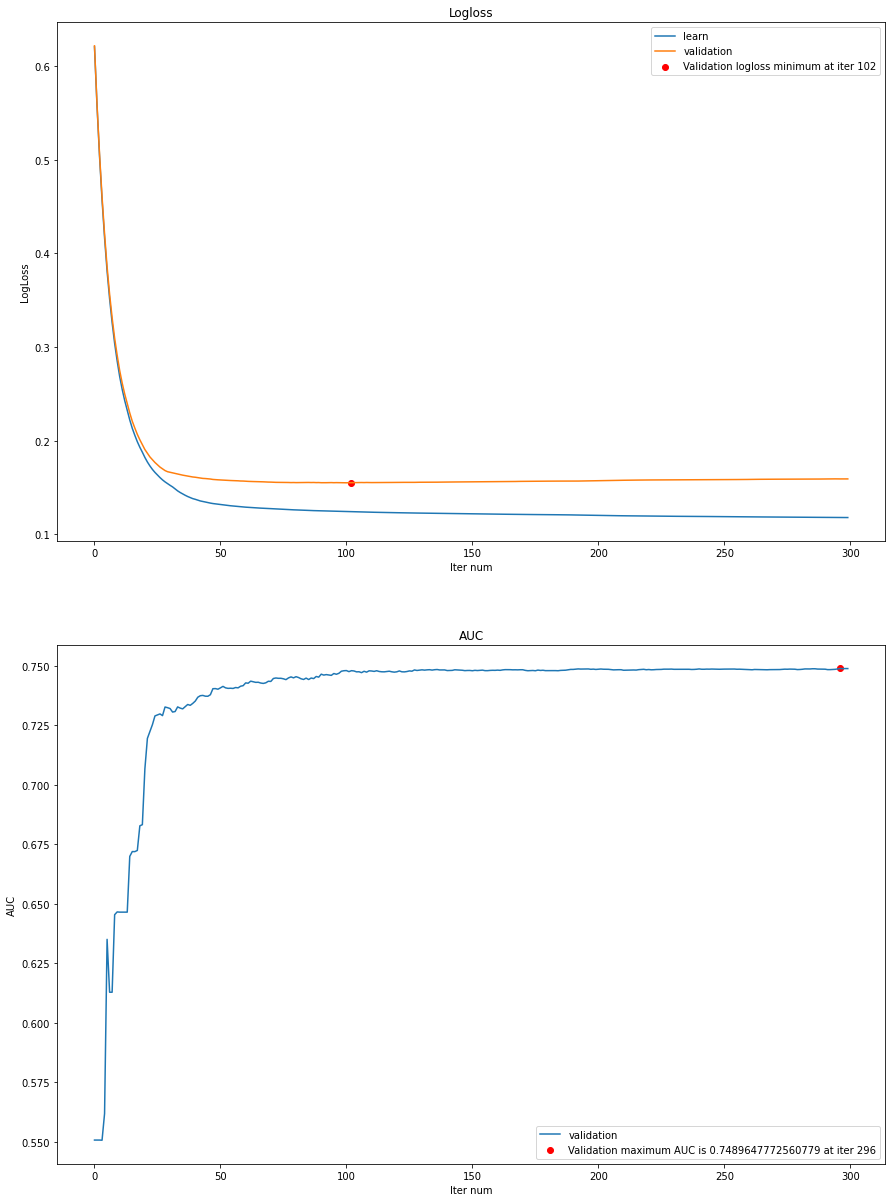

In [237]:
eval_results = model.get_evals_result()
valid_loss_min_iter = np.argmin(eval_results['validation']['Logloss'])
valid_auc_max_iter = np.argmax(eval_results['validation']['AUC'])

fig = plt.figure(figsize=(29.7/2, 21.))

loss_ax = fig.add_subplot(2, 1, 1)
auc_ax = fig.add_subplot(2, 1, 2)

loss_ax.set_title('Logloss')
loss_ax.set_xlabel('Iter num')
loss_ax.set_ylabel('LogLoss')
loss_ax.plot(
    eval_results['learn']['Logloss'],
    label='learn'
)
loss_ax.plot(
    eval_results['validation']['Logloss'],
    label='validation'
)
loss_ax.scatter(
    valid_loss_min_iter,
    eval_results['validation']['Logloss'][valid_loss_min_iter],
    color='r',
    label=f'Validation logloss minimum at iter {valid_loss_min_iter}'
)

auc_ax.set_title('AUC')
auc_ax.set_xlabel('Iter num')
auc_ax.set_ylabel('AUC')
auc_ax.plot(
    eval_results['validation']['AUC'],
    label='validation'
)
auc_ax.scatter(
    valid_auc_max_iter,
    eval_results['validation']['AUC'][valid_auc_max_iter],
    color='r',
    label=f"Validation maximum AUC is {eval_results['validation']['AUC'][valid_auc_max_iter]} at iter {valid_auc_max_iter}"
)

loss_ax.legend()
auc_ax.legend()
plt.show()

In [ ]:
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=valid_pool)


In [ ]:
y_pred = model.predict(X_test)

# Отправка результатов

In [ ]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

# Юнит тестирование


## Подключение библиотек

In [ ]:
import unittest

## Объявление тестирующего класса

In [ ]:
class TestNotebook(unittest.TestCase):
    def test_add(self):
        self.assertEqual(2 + 2, 4)

## Запуск тестов

In [ ]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_add (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK
